In [1]:
# load libs
library(tidyverse)
library(magrittr)
library(ggplot2)
library(rscones2)
library(caret)
library(glmnet)
source("~/projects/wisdom/r/clean_theme.R")

# define variables
## gwas data
wd <- "../datasets/lgm_rr30/"
pedBasename = paste0(wd, "genotypes")
phenoFile = paste0(wd, "phenotype.txt")
netFile = paste0(wd, "gi.txt")
encoding = 0
maf = 0.05

## useful variables
SKAT <- 0
CHISQ <- 1

CONSISTENCY <- 1
AICc <- 2

#define functions
manhattanPlot <- function(sconesOut){
    map %>%
        mutate(score = sconesOut$scores,
                       detected = as.logical(sconesOut$indicator),
                       status = "TN",
                       status = ifelse(detected & causal, "TP", status),
                       status = ifelse(detected & ! causal, "FP", status),
                       status = ifelse(! detected & causal, "FN", status),
                       status = factor(status, levels = c("TP","FN","FP","TN"))) %>%
        arrange(chr, pos) %>%
        ggplot(aes(x = snp, y = score, alpha = status, color = status)) +
            geom_point() +
            labs(x = "Genomic position", y = "Score",
                 color = "Detected") +
            scale_alpha_discrete(range = c(1, 0.25)) +
            clean_theme() + 
            theme(legend.position = "bottom", 
                  axis.text.x = element_blank(),
                  panel.grid.major = element_blank()) + 
            guides(alpha = FALSE)
}

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-5



In [2]:
# read data
## GWAS
gwas <- readBio(pedBasename, phenoFile, netFile, encoding, maf)

## ground truth
truth <- read_tsv(paste0(wd, "truth.tsv"), col_types = "iddccdd") %>% .$causalSnp %>% as.integer

## SNP info
map <- read_tsv(paste0(pedBasename, ".map"), col_names = F, col_types = "icii") %>% 
    set_colnames(c("chr","snp","godknows","pos")) %>%
    mutate(snp = paste(chr, pos, sep = "_"),
           causal = as.logical(truth)) %>%
    select(chr, pos, snp, causal)

## read snp interactions
net <- read_tsv(netFile, col_names = F, col_types = "icii") %>% 
    set_colnames(c("chr","pos","chr2","pos2")) %>%
    mutate(snp1 = paste(chr, pos, sep = "_"),
           snp2 = paste(chr2, pos2, sep = "_")) %>%
    select(snp1, snp2) %>%
    merge(map, by.x = "snp1", by.y = "snp") %>%
    merge(map, by.x = "snp2", by.y = "snp", suffixes = c("1", "2")) %>%
    select(snp1, snp2)

# Goals

* Test different combinations of parameters of SConES in an easy situation where the network contains key information.
* Compare SConES to other methods (LASSO).

# Dataset

* 6 chromosomes.
* 16 causal SNPs in 4 causal genes. 
* Relative risk of 1.2 for each of them. However, they are simulated independently, so RR might be lower than that. Not all the SNPs in one gene are causal.
* Genes interact in sequential pathways A -> B -> C. Some crosstalk has been added (genes interacting with a gene from another pathway). Causal genes have a pathway and but also constitute a clique of their own.

Loading required package: RColorBrewer


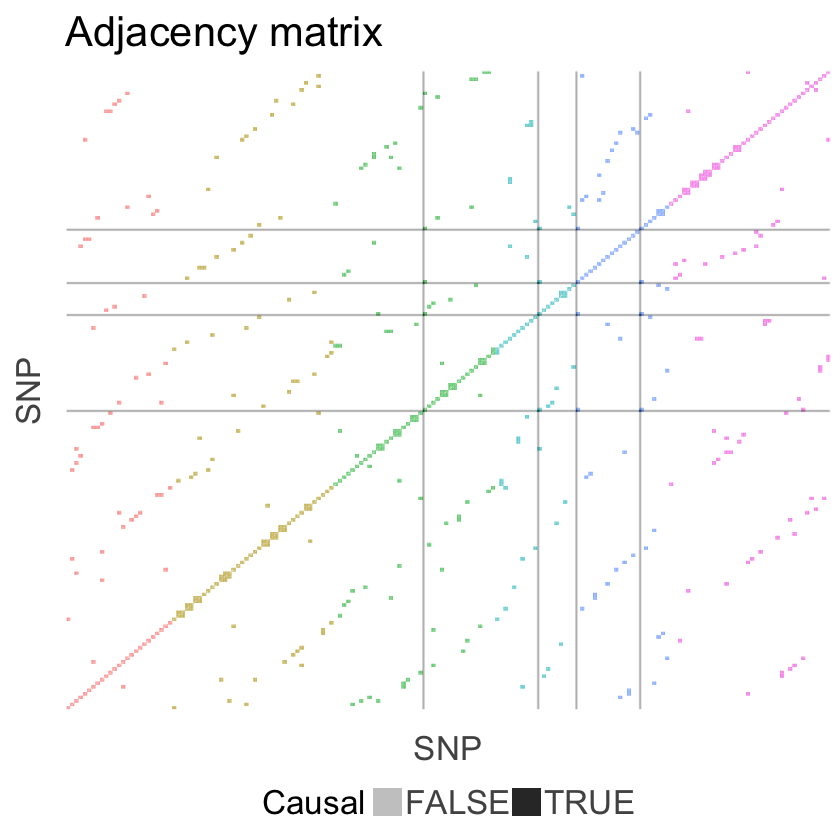

In [3]:
ppi <- net %>% select(snp1,snp2) %>% table  %>%
    apply(1, function(x) x > 0) %>% as.data.frame()  %>%
    mutate(., rs = colnames(.)) %>%
    gather(rs) %>%
    set_colnames(c("snp1", "snp2", "interaction")) %>%
    filter(interaction) %>%
    merge(map, by.x="snp1", by.y="snp") %>%
    merge(map, by.x="snp2", by.y="snp", suffixes = c("1", "2")) %>%
    mutate(snp1 = factor(snp1, levels = map %>% arrange(chr,pos) %>% .$snp),
           snp2 = factor(snp2, levels = map %>% arrange(chr,pos) %>% .$snp),
           interaction = ifelse(interaction, "Yes", "No"))

causalSnpPositions <- which(levels(ppi$snp1) %in% (ppi %>% filter(causal1) %>% .$snp1))

ggplot(ppi, aes(x = snp1, y = snp2, fill = as.character(chr1), 
           alpha = as.character(causal1 & causal2))) +
    geom_tile() +
    geom_vline(xintercept = causalSnpPositions, alpha = 0.1) +
    geom_hline(yintercept = causalSnpPositions, alpha = 0.1) +
    scale_alpha_discrete(range = c(0.3, 1)) +
    labs(x = "SNP", y = "SNP", title = "Adjacency matrix", alpha = "Causal") +
    clean_theme() + 
    theme(legend.position = "bottom", 
          axis.text.x = element_blank(), 
          axis.text.y = element_blank(),
          panel.grid.major = element_blank()) + 
    guides(fill = FALSE)

# AICc
## SKAT

[1] 0.9991592

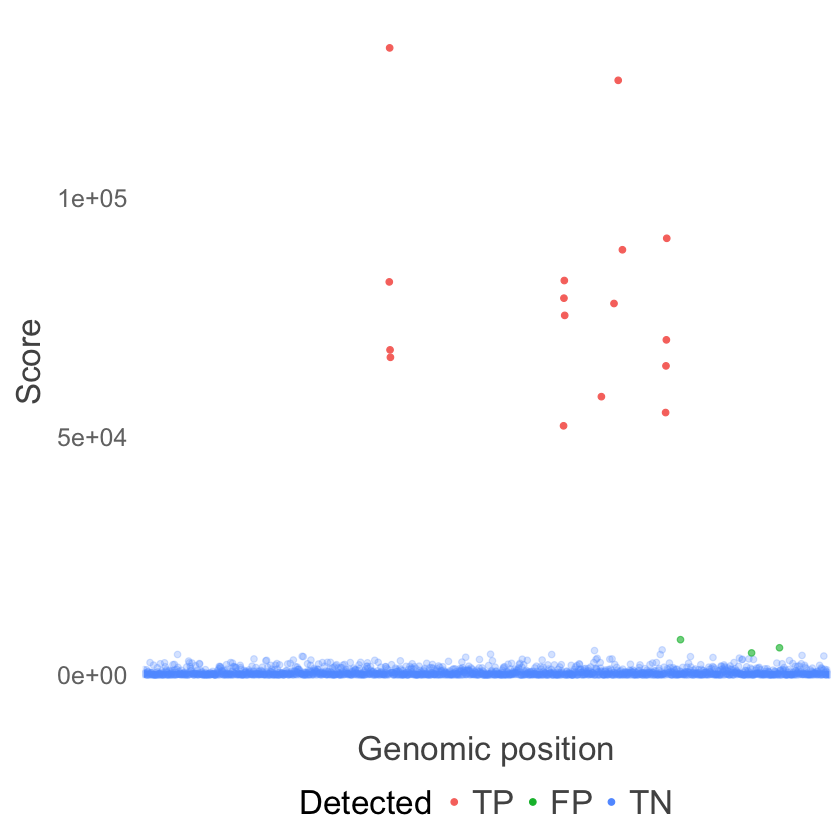

In [4]:
skat <- runScones(gwas$X, gwas$Y, gwas$net, list(test_statistic = SKAT, 
                                                 gridsearch_depth = 3, 
                                                 selection_criterion = AICc))
skat.stats <- confusionMatrix(skat$indicator, truth, positive = '1')
manhattanPlot(skat)
skat.stats$byClass[["Balanced Accuracy"]]

In [5]:
skat$lambda
skat$eta

[1] 3.521005e-12

[1] 2680.082

We are disregarding the connectivity, using mainly the sparsity. Possibly a RR of 1.2 is still too easy.

In [6]:
sum(skat$indicator)

[1] 19

[1] 1

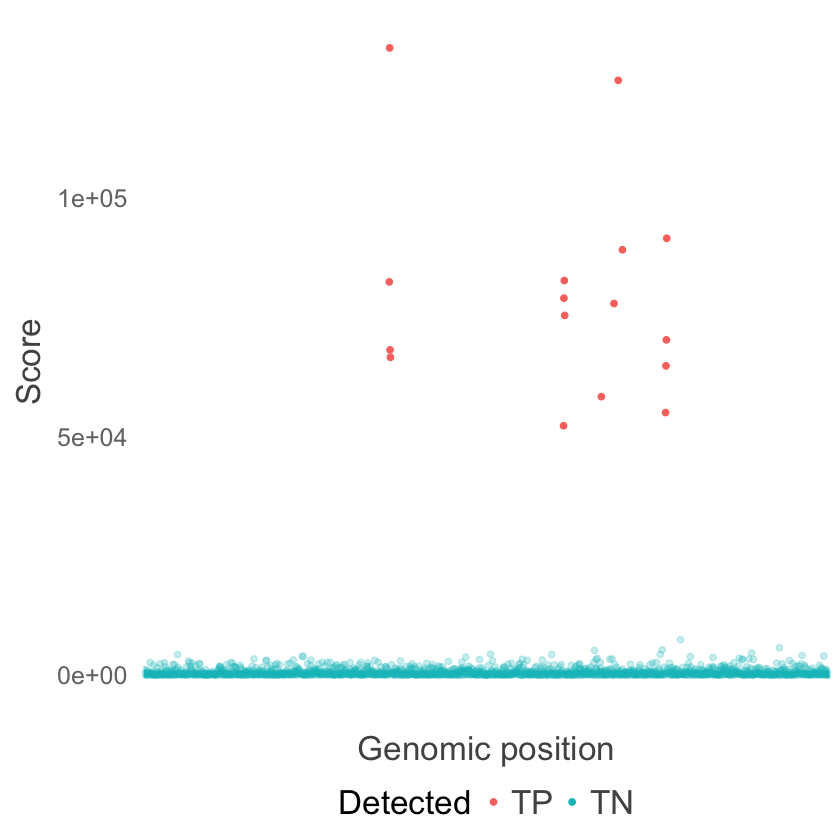

In [7]:
# same lambda, higher eta
skat.sparser <- runScones(gwas$X, gwas$Y, gwas$net, list(test_statistic = SKAT, 
                                                         lambdas = c(3.52e-12), 
                                                         etas = c(7000), 
                                                         autoParameters = FALSE))
skat.sparser.stats <- confusionMatrix(skat.sparser$indicator, truth, positive = '1')
skat.sparser.stats$byClass[["Balanced Accuracy"]]
manhattanPlot(skat.sparser)

As suspected, higher sparsity leads to a better solution.

In [8]:
n <- length(gwas$Y)

best.ss <- sum(skat.sparser$indicator)
ss <- getRegressionStats(gwas$X[,which(as.logical(skat.sparser$indicator))], gwas$Y)

cat("AICc SKAT sparser\n",
    ss$AICc, "=",
    -2 * ss$logLikelihood, "+", 
    2 * sum(skat.sparser$indicator), "+", 
    (2 * best.ss * ( best.ss + 1)) / (n - best.ss - 1), "\n")

best.s <- sum(skat$indicator)
s <- getRegressionStats(gwas$X[,which(as.logical(skat$indicator))], gwas$Y)

cat("AICc SKAT\n",
    s$AICc, "=",
    -2 * s$logLikelihood, "+", 
    2 * sum(skat$indicator), "+", 
    (2 * best.s * ( best.s + 1)) / (n - best.s - 1), "\n")

AICc SKAT sparser
 7238.497 = 7204.395 + 32 + 0.09092429 
AICc SKAT
 7209.714 = 7169.573 + 38 + 0.1270903 


As with simplest example, this solution is not achievable using AICc. Can we achieve an equally better solution by enforcing higher connectivity? Let's see how the solution SNPs are interconnected:

[1] 16

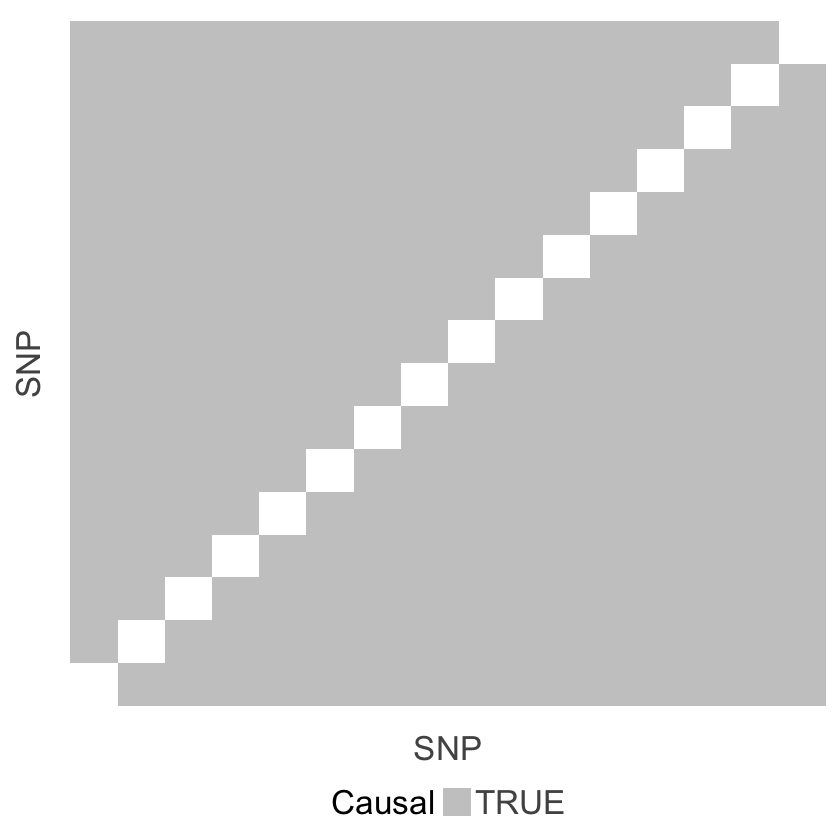

In [9]:
selectedSnps <- filter(map, as.logical(skat$indicator)) %>%
    mutate(snp = paste(chr, pos, sep = "_")) %>%
    .$snp

ppi.selected <- filter(ppi, snp1 %in% selectedSnps & snp2 %in% selectedSnps)
ppi.selected %>% .$snp1 %>% unique %>% length

causalSnpPos <- which(levels(ppi.selected$snp1) %in% (ppi %>% filter(causal1) %>% .$snp1))

ggplot(ppi.selected, aes(x = snp1, y = snp2, 
                         alpha = causal1 & causal2)) +
    geom_tile() +
    geom_vline(xintercept = causalSnpPos, alpha = 0.1) +
    geom_hline(yintercept = causalSnpPos, alpha = 0.1) +
    scale_alpha_discrete(range = c(0.3, 1)) +
    labs(x = "SNP", y = "SNP", alpha = "Causal") +
    clean_theme() + 
    theme(legend.position = "bottom", 
          axis.text.x = element_blank(), 
          axis.text.y = element_blank(),
          panel.grid.major = element_blank()) + 
    guides(fill = FALSE)

Only the causal SNPs are interconnected, meaning that in theory, we should be able to find a better solution just by increasing the weight of the connectivity term:

[1] 1

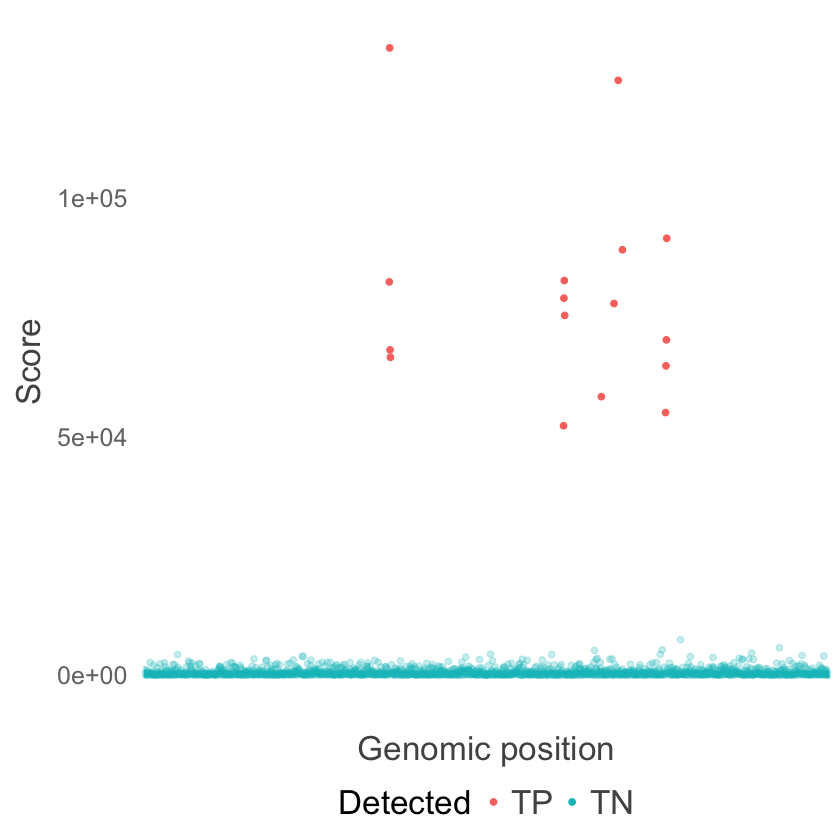

In [10]:
# same eta, higher lambda
skat.connecter <- runScones(gwas$X, gwas$Y, gwas$net, list(test_statistic = SKAT, 
                                                           lambdas = c(100), 
                                                           etas = c(2680.08), 
                                                           autoParameters = FALSE))

skat.connecter.stats <- confusionMatrix(skat.connecter$indicator, truth, positive = '1')
skat.connecter.stats$byClass[["Balanced Accuracy"]]
manhattanPlot(skat.connecter)

## CHISQ

In [11]:
chisq <- runScones(gwas$X, gwas$Y, gwas$net, list(test_statistic = CHISQ, 
                                                  gridsearch_depth = 3, 
                                                  selection_criterion = AICc))
chisq.stats <- confusionMatrix(chisq$indicator, truth, positive = '1')

[1] 0.9983184

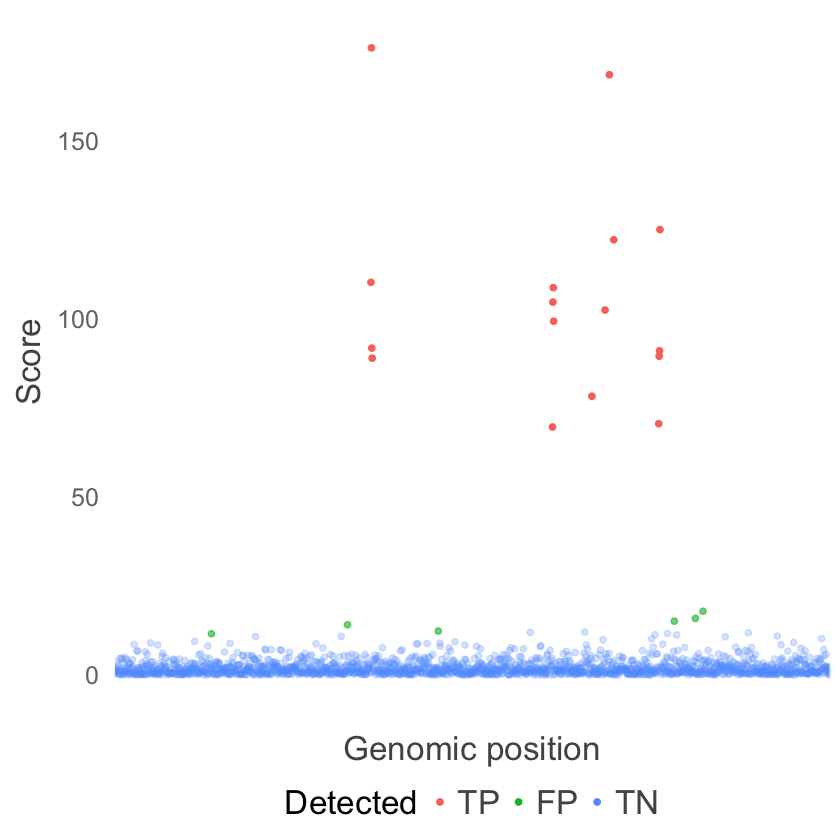

In [12]:
manhattanPlot(chisq)
chisq.stats$byClass[["Balanced Accuracy"]]

In [13]:
sum(chisq$indicator)

[1] 22

The CHISQ statistic works quite worse than SKAT, although still the results are quite acceptable, with a balanced accuracy > 0.99. Let's check the parameters.

In [14]:
chisq$lambda
chisq$eta

# best parameters
fit <- data.frame(skat = skat$scores, chisq = chisq$scores) %>%
    lm( skat ~ chisq, data = .)

skat$lambda/fit$coefficients[2] %>% as.numeric()
skat$eta/fit$coefficients[2] %>% as.numeric()

[1] 2.110787e-07

[1] 8.038688

[1] 4.789227e-15

[1] 3.645415

We are enforcing aproximately the same sparsity as with SKAT, but connectivity is more important.

[1] 16

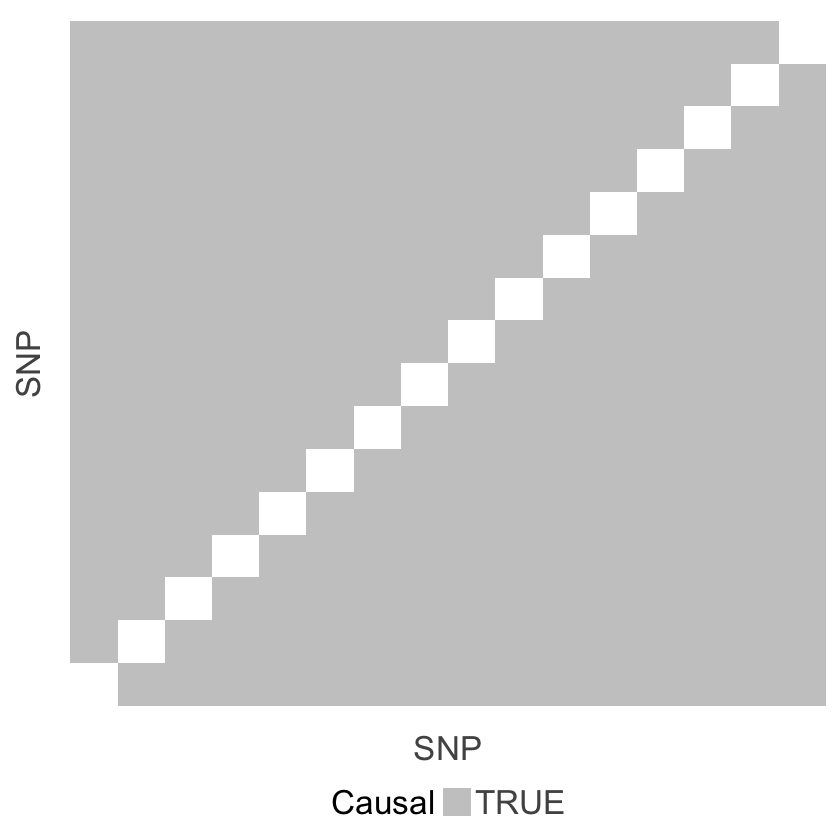

In [15]:
selectedSnps <- filter(map, as.logical(chisq$indicator)) %>%
    mutate(snp = paste(chr, pos, sep = "_")) %>%
    .$snp

ppi.selected <- filter(ppi, snp1 %in% selectedSnps & snp2 %in% selectedSnps)
ppi.selected %>% .$snp1 %>% unique %>% length

causalSnpPos <- which(levels(ppi.selected$snp1) %in% (ppi %>% filter(causal1) %>% .$snp1))

ggplot(ppi.selected, aes(x = snp1, y = snp2, 
                         alpha = causal1 & causal2)) +
    geom_tile() +
    geom_vline(xintercept = causalSnpPos, alpha = 0.1) +
    geom_hline(yintercept = causalSnpPos, alpha = 0.1) +
    scale_alpha_discrete(range = c(0.3, 1)) +
    labs(x = "SNP", y = "SNP", alpha = "Causal") +
    clean_theme() + 
    theme(legend.position = "bottom", 
          axis.text.x = element_blank(), 
          axis.text.y = element_blank(),
          panel.grid.major = element_blank()) + 
    guides(fill = FALSE)

Only 21 / 41 SNPs share an edge in the network. Why are the other 20 SNPs selected?

In [16]:
n <- length(gwas$Y)

best.c <- sum(chisq$indicator)
c <- getRegressionStats(gwas$X[,which(as.logical(chisq$indicator))], gwas$Y)

cat("AICc CHISQ\n",
    c$AICc, "=",
    -2 * c$logLikelihood, "+", 
    2 * sum(chisq$indicator), "+", 
    (2 * best.c * ( best.c + 1)) / (n - best.c - 1), "\n")

best.s <- sum(skat$indicator)
s <- getRegressionStats(gwas$X[,which(as.logical(skat$indicator))], gwas$Y)

cat("AICc SKAT\n",
    s$AICc, "=",
    -2 * s$logLikelihood, "+", 
    2 * sum(skat$indicator), "+", 
    (2 * best.s * ( best.s + 1)) / (n - best.s - 1), "\n")

AICc CHISQ
 7228.761 = 7182.576 + 44 + 0.1693157 
AICc SKAT
 7209.714 = 7169.573 + 38 + 0.1270903 


According to the AICc criteria, this solution is even better than the one found using SKAT due to some overfitting (more likelihood). As we can see from the Manhattan plot, the extra 20 SNPs show a higher CHISQ than the rest of unrelated SNPs, which explains the boost in likelihood. Because with the SKAT statistic all unrelated SNPs have almost the same SKAT, it is unlikely that those correlated SNPs will get picked. In consequence, those models are never tested, and a better solution is achieved.

# Consistency

## SKAT

[1] 1

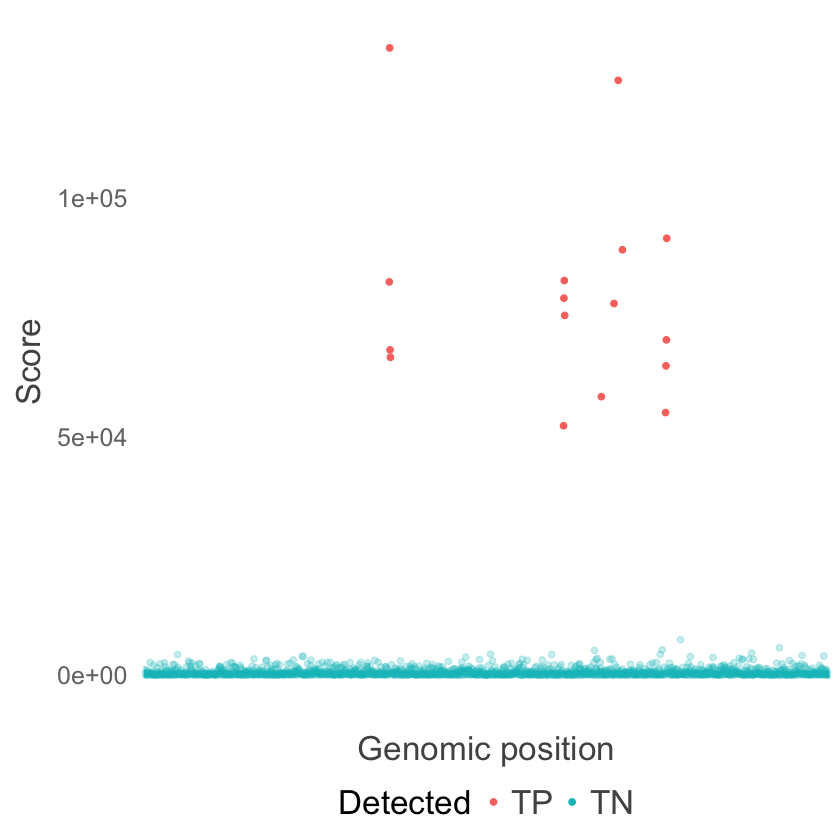

In [17]:
skat.cons <- runScones(gwas$X, gwas$Y, gwas$net, list(test_statistic = SKAT, 
                                                 gridsearch_depth = 3, 
                                                 selection_criterion = CONSISTENCY))
skat.cons.stats <- confusionMatrix(skat.cons$indicator, truth, positive = '1')
manhattanPlot(skat.cons)
skat.cons.stats$byClass[["Balanced Accuracy"]]

## CHISQ

[1] 1

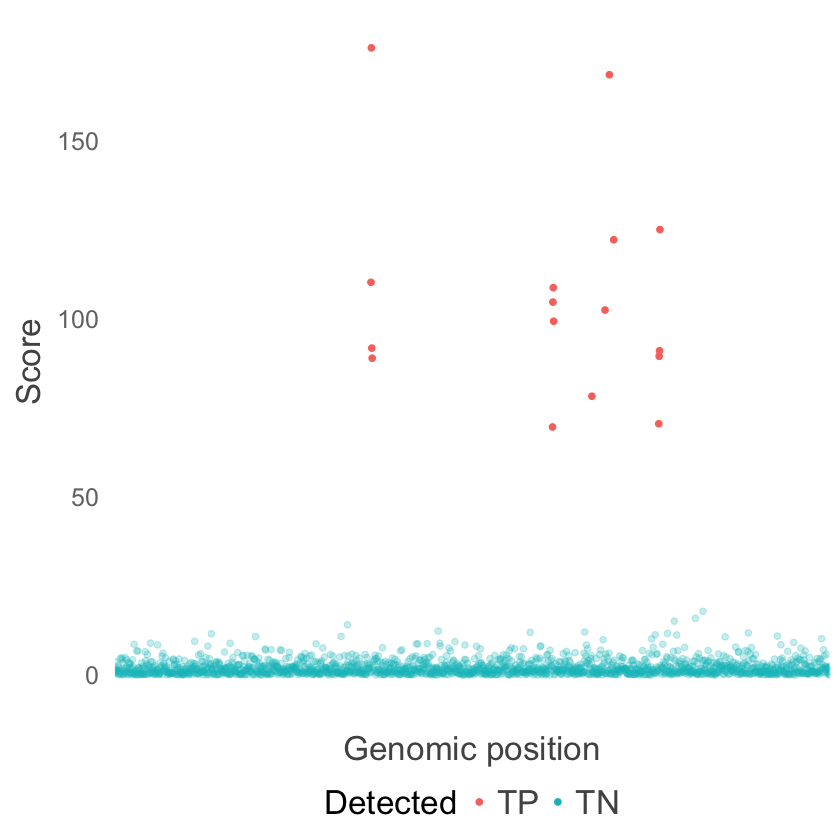

In [18]:
chisq.cons <- runScones(gwas$X, gwas$Y, gwas$net, list(test_statistic = CHISQ, 
                                                 gridsearch_depth = 3, 
                                                 selection_criterion = CONSISTENCY))
chisq.cons.stats <- confusionMatrix(chisq.cons$indicator, truth, positive = '1')
manhattanPlot(chisq.cons)
chisq.cons.stats$byClass[["Balanced Accuracy"]]

Consistency does wonders both in CHISQ and SKAT.

# LASSO

[1] 0.03064004

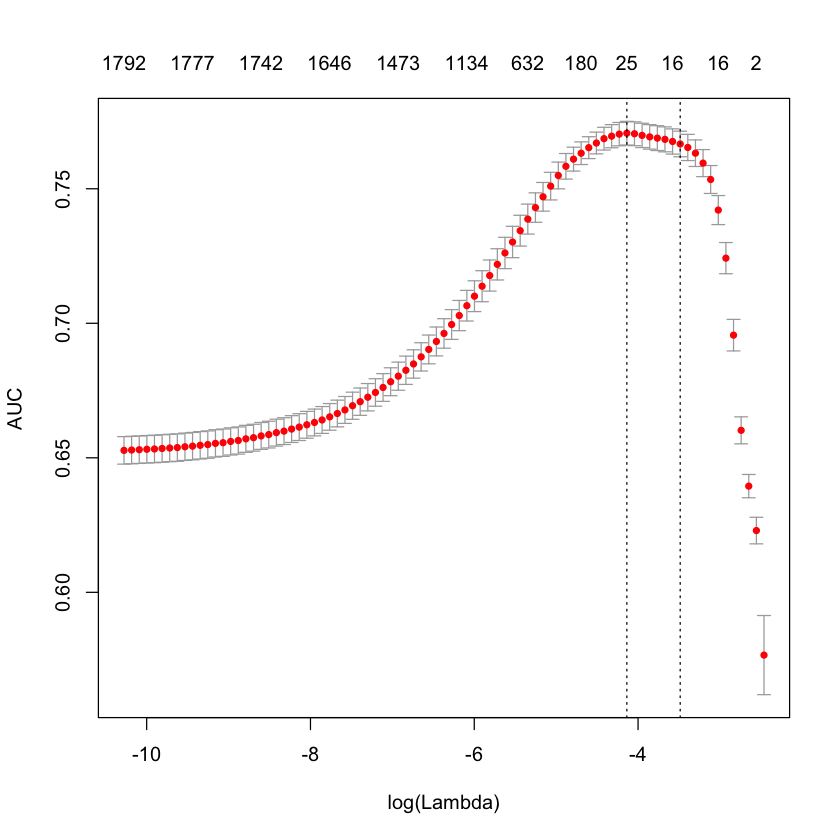

In [19]:
# find best lambda through cross-validation
fit <- cv.glmnet(gwas$X, gwas$Y, family = "binomial", type.measure = "auc")
plot(fit)
fit$lambda.1se

In [20]:
lasso <- glmnet(gwas$X, gwas$Y, lambda = fit$lambda.1se)
lasso.stats <- confusionMatrix(as.numeric(lasso$beta != 0), truth, positive = '1')
lasso.stats$byClass[["Balanced Accuracy"]]

[1] 1

In this case, LASSO can get perfect results. As we could see in previous plots, sparsity could be just enough to find the right solution. And yet we are not finding it. We should alter SConES to find this solution when it is so easily accessible.

# Open questions

About the method:

* Remove the "remove zero rows" in SCones2 CHISQ calculation?
* I am simulating that every patient has an increased likelihood for each one of the SNPs, which shouldn't be the case.

# Future work

* Modify SConES to improve results when only sparsity is necessary.
* Find the minimum RR we can find.
* Re-think the information criteria, as the optimum solution is out of reach. Use BIC to enforce a higher sparsity? Add a term that rewards connectivity? Can it do as well as consistency?